# Overview

This document details the development and evaluation of several supervised machine learning models that identify fraud transactions from a synthetic credit card dataset. It is written by Brandon Shelton in Python 3.7.2 on an AWS t2.2xlarge EC2 Linux instance, and contains 4 sections:

1. **Load and Describe the Data**<br/><br/>

2. **Creating a Plot**<br/><br/>

3. **Data Wrangling**

  - Identifying Reversal-Associated Records
  - Identifying Multi-Swipes<br/><br/>
  
4. **Model Development**
  - Feature Engineering
    - Extracting date parts of `transactionDateTime`
    - `customerId`-specific `transactionAmount` and "time-between-transaction" z-scores
    - `customerId`-specific percent of total transactions and `transactionAmount` for each `merchantCategoryCode`
  - Exploratory Data Analysis
    - Time-series trending of fraudulent and non-fraudulent transactions
    - Pareto of fraudulent transactions by `merchantCategoryCode`
    - Box-plot differences between fraudulent and non-fraudulent transactions for all numeric variables
  - ML Pre-Processing
    - Initial feature selection
    - Splitting the dataset between train and test sets
    - Impute missing values in both train and test sets with the mode values from the train set
    - One-hot encode categorical variables (ensuring both the train and test sets only contain the one-hot encoded train fields)
    - Down-sample train set's majority class
  - Random Forest Development
    - Baseline Random Forest build
    - Random Forest build with Recursive Feature Elimination (RFE)
    - Random Forest build with grid search and RFE-selected features
  - XGBoost Model Development
  - Model Evaluations

# 1. Load and Describe the Data

### Loading the data

The .zip file is downloaded from the specified Amazon S3 bucket and placed in a temporary directory. The json data contained in the transactions.txt file is then uncompressed and loaded as a Pandas dataframe into the Python environment. Once the data is loaded into session memory, the temporary directory is closed.

In [1]:
from IPython.display import display

# Read the zip file from the https link
import urllib.request
from zipfile import ZipFile
from io import BytesIO

url_loc = urllib.request.urlopen('https://s3.us-east-2.amazonaws.com/example.data/transactions.zip')
zfile = ZipFile(BytesIO(url_loc.read()))

# Create the temporary directory to store the zip file's content
import tempfile

temp_dir = tempfile.TemporaryDirectory()

# Extract the zip file's content into the temporary directory
zfile.extractall(temp_dir.name)

# Read the zip file's JSON content into a Pandas dataframe
import os
import pandas as pd

json_path = (temp_dir.name + '/' + os.listdir(temp_dir.name)[0])
data = pd.read_json(json_path, lines = True)

# Close the temporary directory
import shutil
shutil.rmtree(temp_dir.name)

data.shape

(641914, 29)

### Describing the data. 

Evaluate the amount of null values, empty strings values, unique values, and frequency ratio values for each column in the dataset. The frequency ratio is defined as the ratio of the first most frequent value of the column compared to the second most frequent. 

In [2]:
# Check for null values
null_count = data.isnull().sum()

# Check for empty string values
empty_string_count = (data.values == '').sum(axis = 0)

# Check for med_provname_choice values
unique_values = data.nunique()

# Put the three above items together
explore_df = pd.DataFrame({'null_count': null_count,
          'empty_string_count': empty_string_count,
          'unique_values': unique_values})\
.reset_index()\
.sort_values(by = ['empty_string_count', 'unique_values'], ascending = False)

# Check for freqRatio,
# which is the ratio of the first most frequent value compared to the second most frequent
import numpy as np

frequency_ratios = pd.DataFrame([])
def keep_top2(column_name):
    try:
        f2 = data.groupby(column_name).size().reset_index()
        f2.columns = ['value', 'count']
        f3 = f2.nlargest(2, 'count')
        f4 = pd.DataFrame({'index': [column_name], 'freqRatio': f3['count'].iloc[0]/f3['count'].iloc[1]})
        return f4
    except:
        f4 = pd.DataFrame({'index': [column_name], 'freqRatio': np.nan})
        return f4

for i in data.columns:
    f5 = keep_top2(i)
    frequency_ratios = frequency_ratios.append(f5)

# Merge the freqRatio with explore_df and print
pd.merge(explore_df, frequency_ratios, on = 'index')

,index,null_count,empty_string_count,unique_values,freqRatio
0,echoBuffer,0,641914,1,NaN
1,merchantCity,0,641914,1,NaN
2,merchantState,0,641914,1,NaN
3,merchantZip,0,641914,1,NaN
4,posOnPremises,0,641914,1,NaN
5,recurringAuthInd,0,641914,1,NaN
6,acqCountry,0,3913,5,161.590340
7,posEntryMode,0,3345,6,1.323107
8,merchantCountryCode,0,624,5,241.114188
9,transactionType,0,589,4,36.939252


There are only 4 numeric fields included in the data, and a summary of their distributions is included below. From this data, we can tell that the credit limit balance ranges from 250 to 50,000, and the average transaction amount is 135.16, while its max is 1825.25.

In [3]:
# Evaluate summary statistics of relevant numeric columns
data['creditLimit'] = data['creditLimit'].astype(np.float64)
num_data = data.select_dtypes(include = ['float64'])
num_data.describe()

,availableMoney,creditLimit,currentBalance,transactionAmount
count,641914.000000,641914.000000,641914.000000,641914.000000
mean,6652.828573,10697.210608,4044.382035,135.162497
std,9227.132275,11460.359133,5945.510224,147.053302
min,-1244.930000,250.000000,0.000000,0.000000
25%,1114.970000,5000.000000,502.442500,32.320000
50%,3578.165000,7500.000000,2151.860000,85.800000
75%,8169.185000,15000.000000,5005.890000,189.030000
max,50000.000000,50000.000000,47496.500000,1825.250000


In [4]:
# Print the correlation matrix of relevant numeric columns
num_data.corr()

,availableMoney,creditLimit,currentBalance,transactionAmount
availableMoney,1.000000,0.856440,0.098895,-0.011723
creditLimit,0.856440,1.000000,0.598413,0.002400
currentBalance,0.098895,0.598413,1.000000,0.022820
transactionAmount,-0.011723,0.002400,0.022820,1.000000


# 2. Creating a Plot

The histogram plot below describes the distribution of the `transactionAmount`.

In [5]:
import matplotlib.pyplot as plt
import scipy.stats


def histogram_creator(column_name, transformation):
    if transformation == 'box cox':
        x = pd.Series(scipy.stats.boxcox(data[column_name] + .01)[0])
        plot_title = 'Box Cox Distribution of Individual Transaction Amounts'
        x_label = 'Box Cox Transformed Transaction Amount'
        text_x = 15; text_y = 12500
    else:
        x = data[column_name]
        plot_title = 'Distribution of Individual Transaction Amounts'
        x_label = 'Transaction Dollar Amount'
        text_x = 750; text_y = 50000

    plt.rcParams['figure.figsize'] = (12,8)
    plt.rcParams["font.size"] = 18

    result = plt.hist(x, bins = 100, color = 'y', edgecolor = 'k')
    plt.axvline(x.mean(),
                color = 'r',
                linestyle = 'dashed',
                linewidth = 1,
                label = ('Mean: ' + str(round(x.mean(), 2))))
    plt.axvline(x.median(),
                color = 'b',
                linestyle = 'dashed',
                linewidth = 1,
                label = ('Median: ' + str(round(x.median(), 2))))
    plt.legend(loc = 'upper right')
    plt.text(text_x, text_y,
             ('Skewness Coeffiecient: ' +
              str(round(scipy.stats.skew(x), 1))),
             bbox = dict(boxstyle = 'square', alpha = 0.5))
    plt.title(plot_title, color = 'k')
    plt.xlabel(x_label, color = 'k')
    plt.ylabel('Count of Transactions', color = 'k')

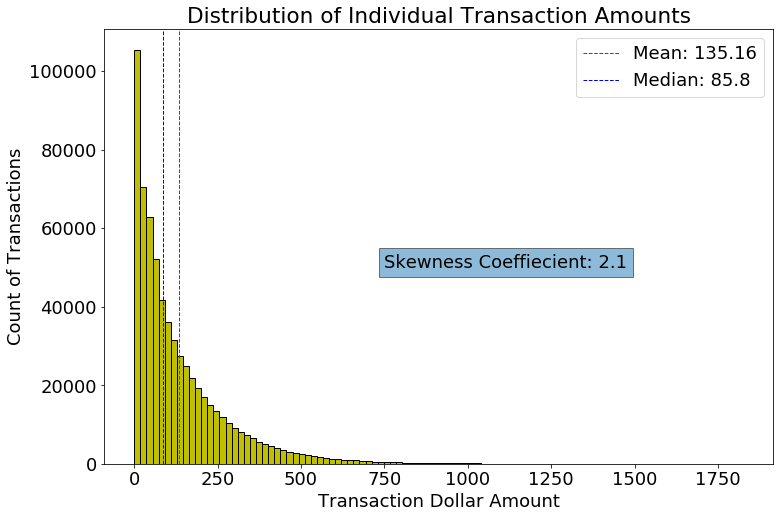

In [6]:
histogram_creator(column_name = 'transactionAmount', transformation = 'none')

The shape of this histogram indicates that the `transactionAmount` variable has an asymetrical disribution with positive skewness. This observation is further validated by the fact that the mean statistic sits to the right of the median statistic, and that the Pearson’s Skewness Coefficient is greater than zero (zero would mean no skewness, less than zero would mean negative skewness).

This observation tells us that the higher range of the cost, the lower the amount of transactions that are likely to occur.

Because the data’s distribution is positively skewed, it would need to be transformed into a more symetrical shape to be appropriately used in a parameteric (linear) model, since parametric models rely on a heavy assumption that data is normally distributed. A transformation option would be to use the Box Cox transformation, as presented below.

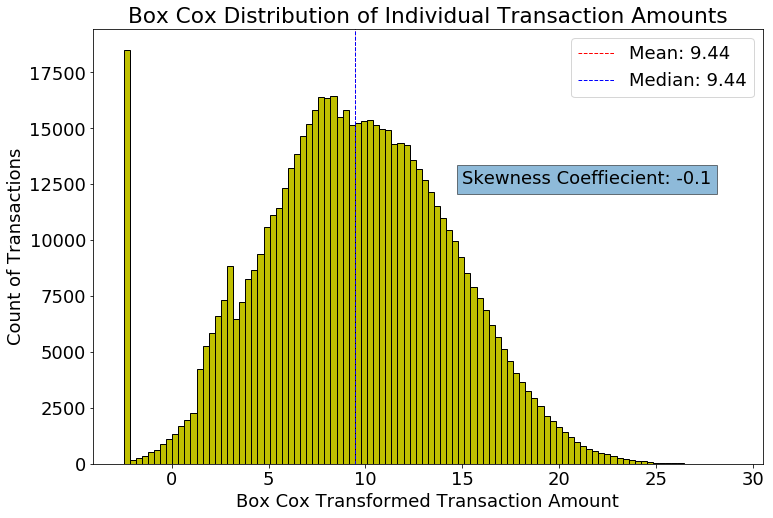

In [7]:
histogram_creator(column_name = 'transactionAmount', transformation = 'box cox')

The distribution now looks much more normal, except for the very high count of $0 transactions still.

Non-parametric models (e.g. decision tree, support vector machine) would not be constrained to using the `transactionAmount` value with its currently skewed distribtion, since non-parametric models do not assume a specific form of its data. For the time being, we will not keep the Box Cox transformation for `transactionAmount`.

# 3. Data Wrangling

### Programmatically Identifying Reversal Transactions

The first of two phenomenons that we need to address is the presence of transaction “reversals” in the data. i.e., a transaction record is followed by a second record that reverses the initial (anchor) transaction.

Furthermore, it may be beneficial to identify the anchor transaction of all reversals too. The code below illustrates the programmatic process of identifying both the anchor and reversal records in the data, as well as giving the total count and dollar amounts for all reversal-associated transactions.

In [8]:
# Filter for just reversals transaction types
reversals = data[data['transactionType'] == 'REVERSAL']

# Summarize reversals and their prevelance in the larger data set
pd.DataFrame({'reversal_count': [len(reversals)],
              'pct_of_total': [round(len(reversals) / len(data), 3)],
              'reversal_dollars': [round(sum(reversals['transactionAmount']), 2)],
              'pct_of_total_dollars': [round(sum(reversals['transactionAmount']) / 
                                      sum(data['transactionAmount']), 3)]},
             columns = ['reversal_count', 'pct_of_total', 'reversal_dollars', 'pct_of_total_dollars'])

# Create a way to identify both reversals and the transaction it was associated with.
data['transactionKey'] = (data['accountNumber'].map(str) + '_' +
                          data['merchantName'].map(str) + '_' +
                          data['transactionDateTime'].str.slice(0, 10).map(str) + '_' +
                          data['transactionAmount'].map(str))

data['datelessTransactionKey'] = (data['accountNumber'].map(str) + '_' +
                                  data['merchantName'].map(str) + '_' +
                                  data['transactionAmount'].map(str))

data = data.sort_values(['datelessTransactionKey', 'merchantName', 'transactionDateTime'])

# Identify a record as a reversal associated record when a `transactionType == 'REVERSAL'`` or
# the next transaction by a `customerId` with a specific `merchantName` for the same amount is a reversal.
data['rev_association'] = np.where((((data['datelessTransactionKey'].shift(-1) == data['datelessTransactionKey']) &
                                     (data['transactionType'].shift(-1) == "REVERSAL")) |
                                    (data['transactionType'] == 'REVERSAL')),
                                   '1',
                                   '0')

# Print an example of several reveral assocations
data[data['rev_association'] == '1'][['accountNumber',
                                      'transactionDateTime',
                                      'merchantName',
                                      'transactionAmount',
                                      'transactionType',
                                      'rev_association']].head(8)

,accountNumber,transactionDateTime,merchantName,transactionAmount,transactionType,rev_association
583531,100547107,2016-08-22T20:35:41,Dunkin' Donuts #164240,223.42,PURCHASE,1
583532,100547107,2016-08-22T20:36:57,Dunkin' Donuts #164240,223.42,REVERSAL,1
583564,100547107,2016-12-19T19:11:13,Subway #540372,316.52,PURCHASE,1
583565,100547107,2016-12-19T19:11:57,Subway #540372,316.52,REVERSAL,1
104583,100634414,2016-06-13T20:49:02,Dunkin' Donuts #48174,85.51,PURCHASE,1
104585,100634414,2016-06-29T09:33:16,Dunkin' Donuts #48174,85.51,REVERSAL,1
104596,100634414,2016-11-22T07:17:10,Renaissance Hotel #696523,127.15,PURCHASE,1
104597,100634414,2016-11-22T07:19:32,Renaissance Hotel #696523,127.15,REVERSAL,1


In [9]:
# Summarize reversal-associated transactions and their prevelance in the larger data set
reversal_assc = data[data['rev_association'] == '1']

pd.DataFrame({'reversal_assc_count': [len(reversal_assc)],
              'pct_of_total': [round(len(reversal_assc) / len(data), 3)],
              'reversal_assc_dollars': [round(sum(reversal_assc['transactionAmount']), 2)],
              'pct_of_total_dollars': [round(sum(reversal_assc['transactionAmount']) / 
                                      sum(data['transactionAmount']), 3)]},
             columns = ['reversal_assc_count', 'pct_of_total', 'reversal_assc_dollars', 'pct_of_total_dollars'])

,reversal_assc_count,pct_of_total,reversal_assc_dollars,pct_of_total_dollars
0,30767,0.048,4364399.3,0.05


### Programmatically Identifying Multi-Swipe Transactions

The second of the two phenomenons that we need to address is the presence of transaction “multi-swipes” in the data. i.e., a transaction that is a duplicate charge of a customer’s card by the same merchant for the same amount in a short timespan. Below is the programmatic approach to counting the number of records and associated dollars with mult-swipes, ensuring that the original swipe associated with the multi-swipe is not included.

In [10]:
# For this exercise, we will consider a multi-swipe to be a duplicate charge of a customer's card by:
# the same merchant, for the same transactionAmount, within a five minute window.

# Format the transactionDateTime field to dtype datetime64.
data['transactionDateTime'] = pd.to_datetime(data['transactionDateTime'])

# Calculate the number of minutes betwen swipes for the same transactionKey.
data['time_from_dupe'] = np.where((data['transactionKey'].shift(1) == data['transactionKey']),
                                  (data['transactionDateTime']-(data['transactionDateTime'].shift(1)))\
                                     .astype('timedelta64[m]'),
                                   np.nan)

# Identify all records where the time of the duplpicate transaction was within 5 min. of
# the same account, merchant, and amount, AND is not a 'REVERSAL'.
data['multi_swipe'] = np.where((data['time_from_dupe'] >= 5) | (pd.isnull(data['time_from_dupe'])) | 
                               (data['transactionType'] == 'REVERSAL'),
                                   '0',
                                   '1')

# Identify unique transactionKey values associated with multi-swipes.
multi_swipe_keys = data[data['multi_swipe'] == '1']['transactionKey'].drop_duplicates()

# View transactions that have the same transactionKey as a multi-swipe key.
data[data['transactionKey'].isin(multi_swipe_keys)][['customerId',
                                                    'transactionDateTime',
                                                    'merchantName',
                                                    'transactionAmount',
                                                    'transactionType',
                                                    'multi_swipe']].head(8)

,customerId,transactionDateTime,merchantName,transactionAmount,transactionType,multi_swipe
122015,100973869,2016-08-18 19:46:54,Lyft,0.00,ADDRESS_VERIFICATION,0
122016,100973869,2016-08-18 19:48:23,Lyft,0.00,ADDRESS_VERIFICATION,1
21091,102307135,2016-05-24 22:52:55,Universe Massage #777394,255.05,PURCHASE,0
21092,102307135,2016-05-24 22:54:22,Universe Massage #777394,255.05,PURCHASE,1
478650,104678966,2016-12-26 21:37:31,AMC #128743,635.18,PURCHASE,0
478651,104678966,2016-12-26 21:38:14,AMC #128743,635.18,PURCHASE,1
81297,104679201,2016-08-17 12:07:06,1st Sandwitch Bar #801388,8.24,PURCHASE,0
81298,104679201,2016-08-17 12:09:11,1st Sandwitch Bar #801388,8.24,PURCHASE,1


In [11]:
# Summarize multi-swipe transactions and their prevelance in the larger data set
multi_swipe = data[data['multi_swipe'] == '1']

pd.DataFrame({'multi_swipe_count': [len(multi_swipe)],
              'pct_of_total': [round(len(multi_swipe) / len(data), 3)],
              'multi_swipe_dollars': [round(sum(multi_swipe['transactionAmount']), 2)],
              'pct_of_total_dollars': [round(sum(multi_swipe['transactionAmount']) / 
                                      sum(data['transactionAmount']), 3)]},
             columns = ['multi_swipe_count', 'pct_of_total', 'multi_swipe_dollars', 'pct_of_total_dollars'])

,multi_swipe_count,pct_of_total,multi_swipe_dollars,pct_of_total_dollars
0,6174,0.01,887108.23,0.01


# 4. Machine Learning

In [12]:
# View the balance (or imblance) of the 'isFraud' field
data['isFraud'].value_counts()

False    630612
True      11302
Name: isFraud, dtype: int64

In [13]:
# View the percent of records that where `'isFraud' == True`
round(len(data[data['isFraud'] == True]) / len(data), 4)

0.0176

The dataset is considered extremely imbalanced.

### Feature Engineering

The section below extracts the month, day of week, and hour of each record's `transactionDateTime`.

In [14]:
# Add fields to indicate the month, dayofweek, and hour of each transaction
data['transactionMonth'] = data['transactionDateTime'].dt.month
data['transactionDayofWeek'] = data['transactionDateTime'].dt.dayofweek
data['transactionHour'] = data['transactionDateTime'].dt.hour

The following section calculates the z-scores of the time from the previous purchase and the `transactionAmount`, at the `customerId` level and the combination of `customerId` and `merchantCategoryCode`. It also calculates the  and `transactionAmount` z-scores at the `merchantCategoryCode` level. 

The mean and standard deviations are captured for each of the above-mentioned combinations so that the z-scores of any future records could be easily calculated if the pipeline was operationalized. 

In [15]:
# Create a variable to measure standardized distinace from 0 in both the time between
# the current transaction and the last transaction of the same merchant type for each customer,
# as well as the dollar amount.
data = data.sort_values(['customerId', 'transactionDateTime'])
data['time_prev'] = np.where((data['customerId'].shift(1) == data['customerId']),
                             (data['transactionDateTime']-(data['transactionDateTime'].shift(1)))\
                                .astype('timedelta64[m]'),
                              np.nan)

# Function for getting standard deviation and mean when grouping by one field
def standardized_pieces(groupby_column_name, column_name):
    return data\
      .groupby([groupby_column_name], as_index = False)[column_name]\
      .aggregate({('std_' + groupby_column_name + column_name): np.std, 
                  ('avg_' + groupby_column_name + column_name): np.mean})

c_time = standardized_pieces('customerId', 'time_prev')
c_amount = standardized_pieces('customerId', 'transactionAmount')
m_amount = standardized_pieces('merchantCategoryCode', 'transactionAmount')

data2 = pd.merge(data, c_time, on = ['customerId'])
data2 = pd.merge(data2, c_amount, on = ['customerId'])
data2 = pd.merge(data2, m_amount, on = ['merchantCategoryCode'])

# Function for calculating z-scores
def single_group_zscores(groupby_column_name, column_name):
    return np.where(((data2[('std_' + groupby_column_name + column_name)].isnull()) |\
                     (data2[column_name].isnull()) |\
                     (data2[('std_' + groupby_column_name + column_name)] == 0)),
                    0,
                    ((data2[column_name] - data2[('avg_' + groupby_column_name + column_name)]) /\
                     data2[('std_' + groupby_column_name + column_name)]))

data2['z_c_tfp'] = single_group_zscores('customerId', 'time_prev')
data2['z_c_ta'] = single_group_zscores('customerId', 'transactionAmount')
data2['z_m_ta'] = single_group_zscores('merchantCategoryCode', 'transactionAmount')


# Get for customerId and merchantCategoryCode
data2 = data2.sort_values(['customerId', 'merchantCategoryCode', 'transactionDateTime'])
data2['time_prev_sim_merch'] = np.where(((data2['customerId'].shift(1) == data2['customerId']) &\
                                         (data2['merchantCategoryCode'].shift(1) == data2['merchantCategoryCode'])),
                                  (data2['transactionDateTime']-(data2['transactionDateTime'].shift(1)))\
                                     .astype('timedelta64[m]'),
                                   np.nan)

# Function for getting standard deviation and mean when grouping by customerId and merchantCategoryCode
def standardized_pieces_multi(column_name):
    return data2\
      .groupby(['customerId', 'merchantCategoryCode'], as_index = False)[column_name]\
      .aggregate({('std_cm' + column_name): np.std, ('avg_cm' + column_name): np.mean})

cm_time = standardized_pieces_multi('time_prev_sim_merch')
cm_amount = standardized_pieces_multi('transactionAmount')

data2 = pd.merge(data2, cm_time, on = ['customerId', 'merchantCategoryCode'])
data2 = pd.merge(data2, cm_amount, on = ['customerId', 'merchantCategoryCode'])

def multi_group_zscores(column_name):
    return np.where(((data2[('std_cm' + column_name)].isnull()) |\
                     (data2[column_name].isnull()) |\
                     (data2[('std_cm' + column_name)] == 0)),
                    0,
                    ((data2[column_name] - data2[('avg_cm' + column_name)]) /\
                     data2[('std_cm' + column_name)]))

data2['z_cm_tfp'] = multi_group_zscores('time_prev_sim_merch')
data2['z_cm_ta'] = multi_group_zscores('transactionAmount')

 The percent of each member's total transactions and total `transactionAmount` spent by the record's specific `merchantCategoryCode` are captured as new features.

In [16]:
cust_merch_agg = data2.groupby(['customerId', 'merchantCategoryCode'], as_index = False)\
  .agg({'transactionAmount': ['count', 'sum']})
cust_merch_agg.columns = ['customerId', 'merchantCategoryCode', 'cat_trans', 'cat_dollars']

cust_agg = data2.groupby(['customerId'], as_index = False)\
  .agg({'transactionAmount': ['count', 'sum']})
cust_agg.columns = ['customerId', 'cust_trans', 'cust_dollars']

cust_perc = pd.merge(cust_merch_agg, cust_agg, on = 'customerId')
cust_perc['perc_cat_trans'] = cust_perc['cat_trans'] / cust_perc['cust_trans']
cust_perc['perc_cat_dollars'] = cust_perc['cat_dollars'] / cust_perc['cust_dollars']
cust_perc = cust_perc.drop(columns = ['cust_trans',
                                      'cust_dollars'], axis = 1)

data2 = pd.merge(data2, cust_perc, on = ['customerId', 'merchantCategoryCode'])
cust_perc.head()

,customerId,merchantCategoryCode,cat_trans,cat_dollars,perc_cat_trans,perc_cat_dollars
0,100547107,fastfood,77,11024.45,0.905882,0.998325
1,100547107,food,1,18.50,0.011765,0.001675
2,100547107,mobileapps,7,0.00,0.082353,0.000000
3,100634414,entertainment,1,0.00,0.041667,0.000000
4,100634414,fastfood,2,171.02,0.083333,0.102292


### Exploratory Data Analysis

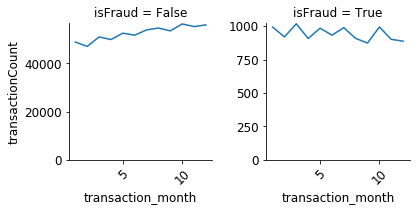

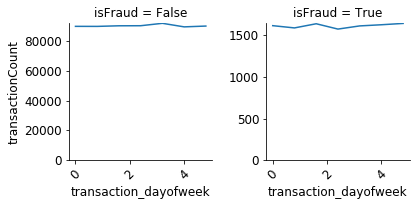

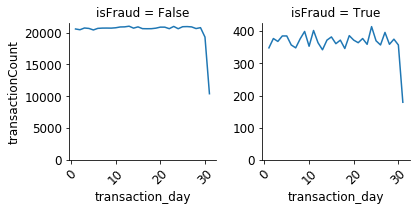

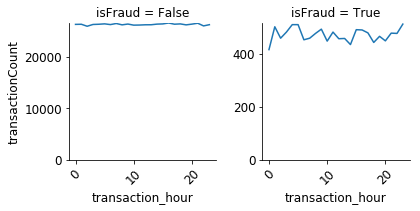

In [17]:
# Display non-Fraud and Fraud transaction volumes over time
import seaborn as sns

def volume_over_time(timepart):
    overtime = data.groupby([getattr(data['transactionDateTime'].dt, timepart), 'isFraud']).size().reset_index()
    overtime.columns = [('transaction_'+ timepart), 'isFraud', 'transactionCount']
    
    plt.rcParams['figure.figsize'] = (12,8)
    plt.rcParams["font.size"] = 12
    
    g = sns.FacetGrid(overtime, col = 'isFraud', col_wrap = 2, sharey = False)
    g.map(plt.plot, ('transaction_'+ timepart), 'transactionCount')
    g.axes[0].set_ylim(0)
    g.axes[1].set_ylim(0)
    g.set_xticklabels(rotation = 45)

for i in ['month', 'dayofweek', 'day', 'hour']:
    volume_over_time(i)

The charts above display the trends of non-fraudulent and fraudulent transactions over different time intervals. The only noticeable pattern is that the non-fraudulent transactions have continued to increase throughout 2016 while fraud transactions have slightly declined.

The chart below displays the percent of transactions that are fraud, and further indicates that the percentage of fraud transactions has slightly decreased throughout 2016.

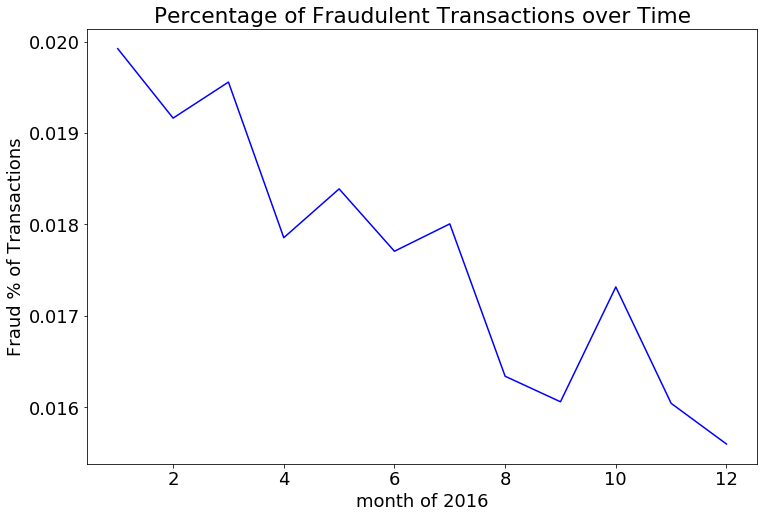

In [18]:
# Display the percentage of fraud transactions over time
def percent_fraud_time(timepart):
    perc_overtime1 = data.groupby([getattr(data['transactionDateTime'].dt, timepart), 'isFraud'])\
      .agg({'transactionAmount': 'count'})
    perc_overtime2 = data.groupby(getattr(data['transactionDateTime'].dt, timepart))\
      .agg({'transactionAmount': 'count'})
    perc_overtime = perc_overtime1.div(perc_overtime2, level = 'transactionDateTime').reset_index()
    perc_overtime.columns = [('transaction_' + timepart), 'isFraud', 'fraud_percentage']
    perc_overtime = perc_overtime[perc_overtime['isFraud'] == 1]

    plt.rcParams['figure.figsize'] = (12,8)
    plt.rcParams["font.size"] = 18
    
    plt.plot(perc_overtime[('transaction_' + timepart)], perc_overtime['fraud_percentage'], color='b')
    plt.title('Percentage of Fraudulent Transactions over Time', color = 'k')
    plt.xlabel((timepart + ' of 2016'), color = 'k')
    plt.ylabel('Fraud % of Transactions', color = 'k')

percent_fraud_time('month')

Per the pareto chart below, the combination of online_retail and fastfood make up almost 50% of all fraudulent transactions.

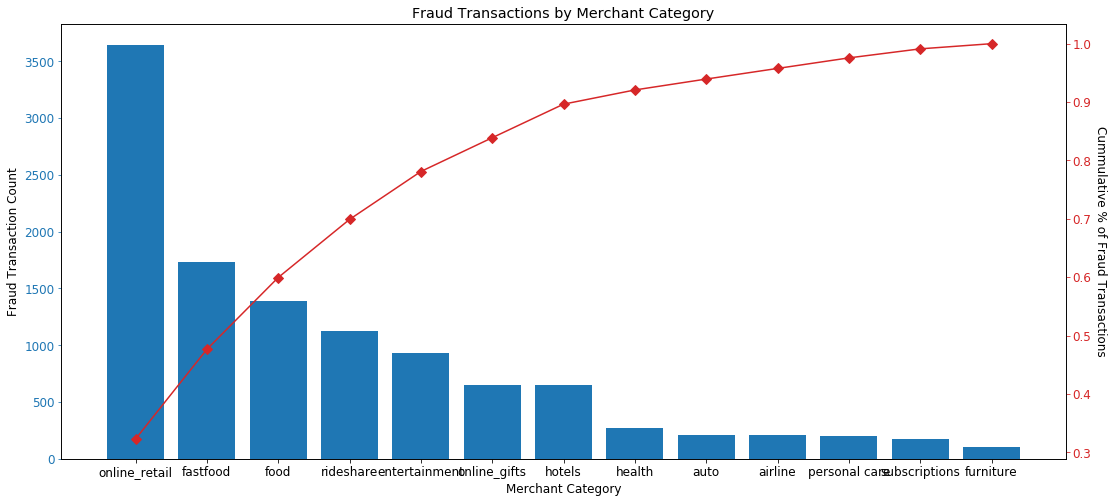

In [19]:
def category_counts():
    byMC = data2[data2['isFraud'] == True].groupby('merchantCategoryCode')\
      .agg({'transactionAmount': 'count'})
    byMC.columns = ['transactionCount']
    byMC = byMC.sort_values('transactionCount', ascending = False)
    byMC['cumpercentage'] = byMC['transactionCount'].cumsum() / byMC['transactionCount'].sum()
    x_pos = np.arange(len(byMC.index))

    plt.rcParams['figure.figsize'] = (18,8)
    plt.rcParams["font.size"] = 12
    
    fig, ax = plt.subplots()
    ax.bar(x_pos, byMC['transactionCount'], color = 'C0')
    ax2 = ax.twinx()
    ax2.plot(x_pos, byMC['cumpercentage'], color = 'C3', marker = 'D', ms = 7)
    ax.tick_params(axis = 'y', colors = 'C0')
    ax2.tick_params(axis = 'y', colors = 'C3')
    ax.grid(False)
    ax2.grid(False)
    plt.xticks(x_pos, byMC.index, rotation = '90')
    plt.title('Fraud Transactions by Merchant Category')
    ax.set_xlabel('Merchant Category')
    ax.set_ylabel('Fraud Transaction Count')
    ax2.set_ylabel('Cummulative % of Fraud Transactions', rotation = 270, labelpad = 15)

category_counts()

Using the boxplots below, it seems as though there is a difference between fraudulent and non-fraudulent transactions for `transactionAmount` and the z-score `transactionAmount`s at the `customerId` (`z_c_ta`), `merchantCategoryCode` (`z_m_ta`), and combination (`z_cm_ta`) variables. Please note that outliers have been excluded from boxplot visualizations.

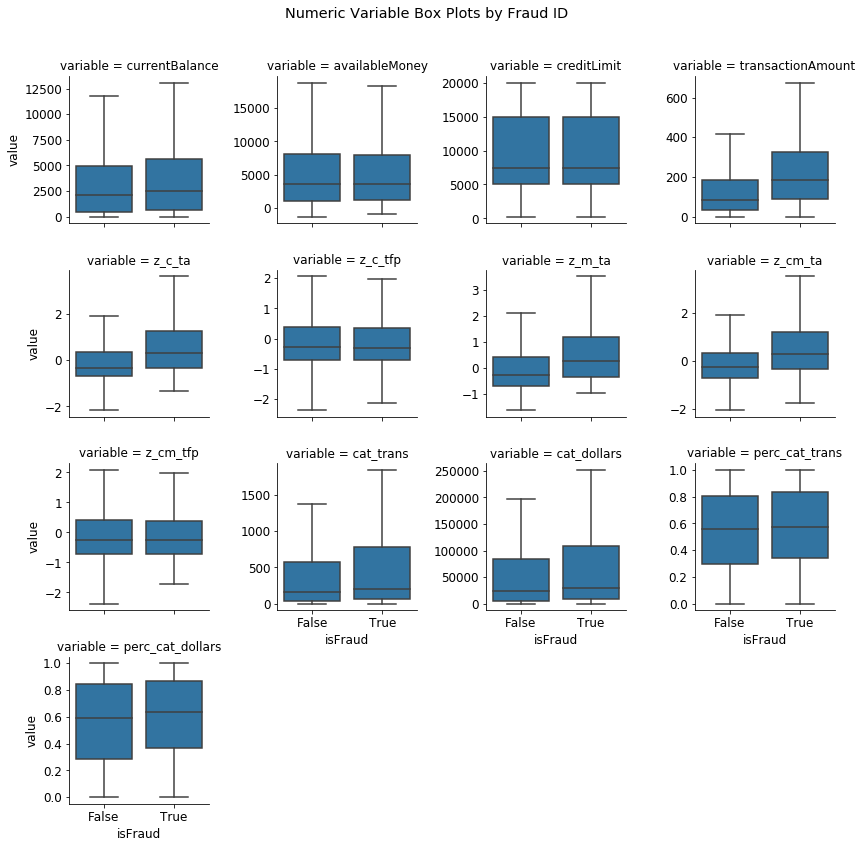

In [20]:
def numeric_boxplots():
    melted = data2.melt(id_vars = 'isFraud', value_vars = ['currentBalance',
                                                           'availableMoney',
                                                           'creditLimit',
                                                           'transactionAmount',
                                                           'z_c_ta',
                                                           'z_c_tfp',
                                                           'z_m_ta',
                                                           'z_cm_ta',
                                                           'z_cm_tfp',
                                                           'cat_trans',
                                                           'cat_dollars',
                                                           'perc_cat_trans',
                                                           'perc_cat_dollars'])

    g = sns.FacetGrid(melted, col = 'variable', col_wrap = 4, sharey = False)
    g.map(sns.boxplot, 'isFraud', 'value', showfliers = False, order = [False, True])
    g.fig.subplots_adjust(top = 0.9)
    g.fig.suptitle('Numeric Variable Box Plots by Fraud ID')

numeric_boxplots()

Two types of supervised machine learning models have been chosen for training on this data: Random Forest and Gradient Boosting. Both models leverage ensembles of trees to choose the most appropriate combinations of weights, but Random Forest models are decision trees that are independently ran with a bagging (i.e., bootstrap aggregation) sub-sampling method for every tree that also uses a pre-defined number of random predictor variables to test at every split. The ensemble of independent trees help Random Forest from over-fitting its predictions (i.e., reduces variance), which is a problem that a single decision tree can often have.

Gradient Boosting primarily differs from Random Forest due to the fact that its trees are built sequentially and each tree focuses on the specific errors of the tree before it to better train “weak learners”. Gradient Boosting’s nature of learning from errors makes it more prone to over-fitting on its training data, so parameters need to be tuned to ensure that a healthy bias-variance tradeoff is found.

Both Random Forest and Gradient Boosting are non-parametric machine learning models. They do not assume a Gaussian distribution of the data, nor are they unduly affected by highly-correlated predictor variables. Because of these factors, neither scaling nor feature reduction will be performed in this exercise.

Due to the heavily imbalanced Class label, techniques will be applied to balance the training data’s Class labels in order for the model to better recognize the minority class. The test data’s Class prevelance will not be altered.

The Area Under the Curve will be used as the measure of performance. The Area Under the Curve measures the trade-off between True Positives (Sensitivity) and False Positives (1 - Specificity). i.e., how good is the model at finding correct fraud transactions while not mis-labeling too many non-fraud transactions as “fraud” in the process? This is balance is important to banks because there is a trade-off for the organization in being able to stop true fraud and causing unnecessary inconveniences to its customers when it intervenes on fraud false positives.

### Pre-Processing

#### Initial Feature Selection

In [21]:
initSet = data2[['isFraud',
                 'creditLimit',
                 'availableMoney',
                 'transactionAmount',
                 'currentBalance',
                 'transactionMonth',
                 'transactionDayofWeek',
                 'transactionHour',
                 'z_c_ta',
                 'z_c_tfp',
                 'z_m_ta',
                 'z_cm_ta',
                 'z_cm_tfp',
                 'acqCountry',
                 'merchantCountryCode',
                 'merchantCategoryCode',
                 'posEntryMode',
                 'posConditionCode',
                 'transactionType',
                 'cardPresent',
                 'expirationDateKeyInMatch',
                 'rev_association',
                 'multi_swipe',
                 'cat_trans',
                 'cat_dollars',
                 'perc_cat_trans',
                 'perc_cat_dollars']]

import warnings
from pandas.core.common import SettingWithCopyWarning
   
with warnings.catch_warnings():
    warnings.simplefilter(action = "ignore", category=SettingWithCopyWarning)
    initSet['label'] = np.where(initSet['isFraud'] == True, 1, 0)
    
initSet = initSet.drop('isFraud', axis = 1)

del [data, data2]

# Check out the data pulled into initSet.
initSet.shape

(641914, 27)

In [22]:
# Convert all non-float64 dtypes to 'str'.
initSet[['transactionMonth',
         'transactionDayofWeek',
         'transactionHour',
         'cardPresent',
         'expirationDateKeyInMatch']] = initSet[['transactionMonth',
                                                 'transactionDayofWeek',
                                                 'transactionHour',
                                                 'cardPresent',
                                                 'expirationDateKeyInMatch']].astype(str)

# Replace all blank strings with np.nan.
initSet = initSet.replace(r'^\s*$', np.nan, regex = True)

# Check for null values
null_count = initSet.isnull().sum()

# Check for empty string values
empty_string_count = (initSet.values == '').sum(axis = 0)

# Check for med_provname_choice values
unique_values = initSet.nunique()

# Put the three above items together
explore_initSet = pd.DataFrame({'null_count': null_count,
                                'empty_string_count': empty_string_count,
                                'unique_values': unique_values})\
  .reset_index()\
  .sort_values(by = ['empty_string_count', 'unique_values'], ascending = False)

frequency_ratios = pd.DataFrame([])
def keep_top2(column_name):
    try:
        f2 = initSet.groupby(column_name).size().reset_index()
        f2.columns = ['value', 'count']
        f3 = f2.nlargest(2, 'count')
        f4 = pd.DataFrame({'index': [column_name], 'freqRatio': f3['count'].iloc[0]/f3['count'].iloc[1]})
        return f4
    except:
        f4 = pd.DataFrame({'index': [column_name], 'freqRatio': np.nan})
        return f4

for i in initSet.columns:
    f5 = keep_top2(i)
    frequency_ratios = frequency_ratios.append(f5)
    
# Merge the freqRatio with explore_df and print
pd.merge(explore_initSet, frequency_ratios, on = 'index')\
  .sort_values(by = ['null_count', 'empty_string_count', 'unique_values'], ascending = False)


,index,null_count,empty_string_count,unique_values,freqRatio
18,acqCountry,3913,0,4,240.785605
17,posEntryMode,3345,0,5,1.323107
19,merchantCountryCode,624,0,4,241.114188
21,transactionType,589,0,3,36.939252
20,posConditionCode,287,0,3,4.231394
8,perc_cat_dollars,11,0,20447,1.690676
0,z_c_ta,0,0,558481,1.165441
1,z_cm_ta,0,0,553730,63.233898
2,z_cm_tfp,0,0,524091,26.896471
3,z_c_tfp,0,0,489924,18.629630


#### Splitting the dataset between train and test sets

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(initSet.drop('label', axis = 1),
                                                    initSet['label'],
                                                    test_size = 0.30,
                                                    random_state = 42)

display('Training set shape = ' + str(X_train.shape))
display('Testing set shape = ' + str(X_test.shape))

'Training set shape = (449339, 26)'

'Testing set shape = (192575, 26)'

#### Impute missing values in both train and test sets with the mode values from the train set

In [24]:
null_count = initSet.isnull().sum()

for i in null_count[null_count > 0].index:
    X_train[i].fillna(X_train[i].mode()[0], inplace = True)
    X_test[i].fillna(X_train[i].mode()[0], inplace = True)

# Validate that there are no more nulls
display('Number of null values in training set = ' + str(X_train.isnull().sum().sum()))
display('Number of null values in training set = ' + str(X_test.isnull().sum().sum()))

'Number of null values in training set = 0'

'Number of null values in training set = 0'

#### One-hot encode categorical variables (ensuring both the train and test sets only contain the one-hot encoded train fields)

In [25]:
train_X = pd.get_dummies(X_train)
test_X = pd.get_dummies(X_test)

# Check to see if there are dummy variables in the train set that aren't in the test set,
# and synthetically create the variables in the test set.
missing_cols = set(train_X.columns) - set(test_X.columns)

if len(missing_cols) == 0:
    display('Train set does not contain any fields not included in test set.')
else:
    for i in missing_cols:
        test_X[i] = 0
        display(test_X[i].name + ' variable synthetically created in test set.')

# Ensure that the test set does not have any dummy variables not included in the train set
# and that the variables are in the same order.
test_X = test_X[train_X.columns]

display('One-hot encoded train set shape:')
display(train_X.shape)

display('One-hot encoded test set shape:')
display(test_X.shape)

'Train set does not contain any fields not included in test set.'

'One-hot encoded train set shape:'

(449339, 102)

'One-hot encoded test set shape:'

(192575, 102)

#### Downsampling

Due to the labeled outcome's strong imbalance in the dataset, the train set's minority class is downsampled to make the label distribution even between fraud and non-fraud transactions.

In [26]:
from sklearn.utils import resample

train_Xy = pd.concat([train_X, y_train], axis = 1)
display('Pre-resampling counts:')
display(train_Xy['label'].value_counts())

train0 = train_Xy[train_Xy['label'] == 0]
train1 = train_Xy[train_Xy['label'] == 1]

# Downsample the majority class
train0_downsampled = resample(train0,
                              replace = False,
                              n_samples = len(train1),
                              random_state = 123)

# Combine minority class with downsampled majority class
train = pd.concat([train0_downsampled, train1], axis = 0)

# Display new class counts
display('Post-resamping counts:')
display(train['label'].value_counts())

train_X = train.drop('label', axis = 1)
train_y = train['label']

'Pre-resampling counts:'

0    441440
1      7899
Name: label, dtype: int64

'Post-resamping counts:'

1    7899
0    7899
Name: label, dtype: int64

### Random Forest Development

#### Baseline Random Forest build

In [40]:
from sklearn.ensemble import RandomForestClassifier

with warnings.catch_warnings():
    warnings.simplefilter(action = "ignore", category = DeprecationWarning)
    
    base_rf = RandomForestClassifier(n_estimators = 200,
                                 bootstrap = True,
                                 max_features = 'sqrt')
    
    base_rf.fit(train_X, train_y)
    
    # Predict on the test set
    rf_base_predictions = base_rf.predict(test_X)

    # Probabilities for each class
    rf_base_probs = base_rf.predict_proba(test_X)[:, 1]

#### Random Forest build with Recursive Feature Elimination (RFE)

In [41]:
from sklearn.feature_selection import RFE

# Extract the 75 most important features from the base random forest model.
rfe_rf = RFE(base_rf, 75)

rfe_rf.fit(train_X, train_y)

# Predict on the test set
rfe_rf_predictions = rfe_rf.predict(test_X)

# Probabilities for each class
rfe_rf_probs = rfe_rf.predict_proba(test_X)[:, 1]

#### Random Forest build with grid search and RFE-selected features

In [42]:
# Limit new train and test sets to only the 75 features retained by the RFE model.
rfe_keep = pd.DataFrame({'column_names': train_X.columns,
                         'keep_or_not': rfe_rf.ranking_})
rfe_keep = rfe_keep[rfe_keep['keep_or_not'] == 1]

train_X2 = train_X[rfe_keep.column_names]
test_X2 = test_X[rfe_keep.column_names]

display('RFE-selected training set shape:')
display(train_X2.shape)


from sklearn.model_selection import GridSearchCV

# Set the hyperparameters on which to grid search
n_estimators = [200, 1000, 2000]
max_features = ['sqrt']
max_depth = [20, 40, 60]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 3]
bootstrap = [True]

grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
               }

grid_search = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = grid_search,
                       param_grid = grid_params,
                       cv = 4,
                       scoring = 'roc_auc',
                       verbose = 0,
                       n_jobs = -1)

# Fit grid search model
rf_grid.fit(train_X2, train_y)

# Predict on the test set
rf_grid_predictions = rf_grid.predict(test_X2)

# Probabilities for each class
rf_grid_probs = rf_grid.predict_proba(test_X2)[:, 1]

# View the best fit parameters
display(rf_grid.best_params_)

'RFE-selected training set shape:'

(15798, 75)

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 2000}

### XGBoost Development

For the XGBoost model, an upsample of the minority class is used to train instead of the downsample method used in the Random Forest builds.

In [43]:
# Further split the train set for an XGBoost watchlist
X_train_tr, X_train_watchlist, y_train_tr, y_train_watchlist = train_test_split(train_Xy.drop('label', axis = 1),
                                                                                train_Xy['label'],
                                                                                test_size = 0.10,
                                                                                random_state = 42)



display('Training set shape = ' + str(X_train_tr.shape))
display('Watchlist set shape = ' + str(X_train_watchlist.shape))


Xy_train_tr = pd.concat([X_train_tr, y_train_tr], axis = 1)

display('Pre-resampling counts:')
display(Xy_train_tr['label'].value_counts())


train0 = Xy_train_tr[Xy_train_tr['label'] == 0]
train1 = Xy_train_tr[Xy_train_tr['label'] == 1]

# Upsample the minority class
train1_upsampled = resample(train1,
                            replace = True,
                            n_samples = len(train0),
                            random_state = 123)

# Combine minority class with downsampled majority class
up_train = pd.concat([train1_upsampled, train0], axis = 0)


# Display new class counts
display('Post-resamping counts:')
display(up_train['label'].value_counts())

'Training set shape = (404405, 102)'

'Watchlist set shape = (44934, 102)'

'Pre-resampling counts:'

0    397286
1      7119
Name: label, dtype: int64

'Post-resamping counts:'

1    397286
0    397286
Name: label, dtype: int64

In [44]:
import xgboost as xgb
from scipy.sparse import csr_matrix

# Transform datasets into sparse matrices for quicker training
sparse_train_X = csr_matrix(up_train.drop('label', axis = 1))
sparse_train_watchlist = csr_matrix(X_train_watchlist)
sparse_test_X = csr_matrix(test_X)

# Set up data to be consumed by the XGBoost model
xgb_train = xgb.DMatrix(sparse_train_X, 
                        label = up_train['label'], 
                        feature_names = X_train_tr.columns)
xgb_watchlist = xgb.DMatrix(sparse_train_watchlist, 
                            label = y_train_watchlist, 
                            feature_names = X_train_watchlist.columns)
xgb_test = xgb.DMatrix(sparse_test_X, 
                       label = y_test, 
                       feature_names = test_X.columns)

# Set the gradient boosting parameters
params = {'max_depth': 4, 
          'eta': .1, 
          'silent': 0, 
          'objective': 'binary:logistic',
          'eval_metric': 'auc'}

# Train the model, using a maximum of 500 trees,
# but stopping early if no additional AUC increase is observed on the watchlist for 25 rounds.
bst = xgb.train(params = params, 
                dtrain = xgb_train, 
                num_boost_round = 500,
                evals = [(xgb_watchlist, 'watchlist')],
                early_stopping_rounds = 25)

[0]	watchlist-auc:0.72179
Will train until watchlist-auc hasn't improved in 25 rounds.
[1]	watchlist-auc:0.729831
[2]	watchlist-auc:0.731052
[3]	watchlist-auc:0.734655
...
[189]	watchlist-auc:0.786623
...
[212]	watchlist-auc:0.786322
[213]	watchlist-auc:0.786332
[214]	watchlist-auc:0.786302
Stopping. Best iteration:
[189]	watchlist-auc:0.786623



In [45]:
xgb_probs = bst.predict(xgb_test)
xgb_predictions = np.where(xgb_probs >= .5, 1, 0)

### Model Evaluations

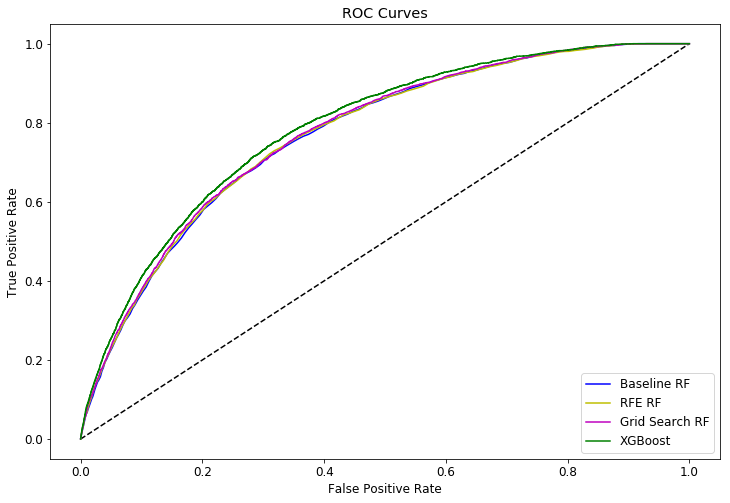

In [46]:
# Create ROC Graph
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

default = {}
default['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
default['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
default['roc'] = 0.5

baseline = {}
baseline['recall'] = recall_score(y_test, rf_base_predictions)
baseline['precision'] = precision_score(y_test, rf_base_predictions)
baseline['roc'] = roc_auc_score(y_test, rf_base_probs)

rfe = {}
rfe['recall'] = recall_score(y_test, rfe_rf_predictions)
rfe['precision'] = precision_score(y_test, rfe_rf_predictions)
rfe['roc'] = roc_auc_score(y_test, rfe_rf_probs)

grid = {}
grid['recall'] = recall_score(y_test, rf_grid_predictions)
grid['precision'] = precision_score(y_test, rf_grid_predictions)
grid['roc'] = roc_auc_score(y_test, rf_grid_probs)

boost = {}
boost['recall'] = recall_score(y_test, xgb_predictions)
boost['precision'] = precision_score(y_test, xgb_predictions)
boost['roc'] = roc_auc_score(y_test, xgb_probs)

default_fpr, default_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
base_fpr, base_tpr, _ = roc_curve(y_test, rf_base_probs)
rfe_fpr, rfe_tpr, _ = roc_curve(y_test, rfe_rf_probs)
grid_fpr, grid_tpr, _ = roc_curve(y_test, rf_grid_probs)
boost_fpr, boost_tpr, _ = roc_curve(y_test, xgb_probs)

def final_roc_chart():
    plt.figure(figsize = (12, 8))
    plt.rcParams['font.size'] = 12
    plt.plot(default_fpr, default_tpr, color = 'k', linestyle = 'dashed')
    plt.plot(base_fpr, base_tpr, color = 'b', label = 'Baseline RF')
    plt.plot(rfe_fpr, rfe_tpr, color = 'y', label = 'RFE RF')
    plt.plot(grid_fpr, grid_tpr, color = 'm', label = 'Grid Search RF')
    plt.plot(boost_fpr, boost_tpr, color = 'g', label = 'XGBoost')
    plt.legend(loc = 'lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')

final_roc_chart()

In [47]:
# Display the AUC scores for the different models
display('Baseline Random Forest AUC: ' + str(roc_auc_score(y_test, rf_base_probs)))
display('Reduced Feature Random Forest AUC: ' + str(roc_auc_score(y_test, rfe_rf_probs)))
display('Grid Search Random Forest AUC: ' + str(roc_auc_score(y_test, rf_grid_probs)))
display('XGBoost AUC: ' + str(roc_auc_score(y_test, xgb_probs)))

'Baseline Random Forest AUC: 0.7700162464347544'

'Reduced Feature Random Forest AUC: 0.7708223413987687'

'Grid Search Random Forest AUC: 0.7743156445591723'

'XGBoost AUC: 0.7865243198596896'

All 4 models are very close in performance, but the up-sampled XGBoost model slightly out-performed the Random Forest models. With additional time, a logloss performance comparison would be evaluated in addition to AUC. In situations where models are relatively close to each other in AUC (which takes into account appropriate labeling), logloss would weigh the prediction probabilities’ confidence in their label, rather than just whether the predicted label agreed with the ground truth label.